In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

index = sys.path.index('')
sys.path.pop(index)
path = sys.path[0]
parent_dir = os.path.abspath(os.path.join(path, os.pardir))

for root, dirs, files in os.walk(parent_dir):
    for dir in dirs:
        sys.path.append(os.path.join(root, dir))

sys.path.append(parent_dir)
sys.path.pop(0)
print(sys.path)

['/Users/khatran/miniconda3/envs/quantum/lib/python310.zip', '/Users/khatran/miniconda3/envs/quantum/lib/python3.10', '/Users/khatran/miniconda3/envs/quantum/lib/python3.10/lib-dynload', '/Users/khatran/miniconda3/envs/quantum/lib/python3.10/site-packages', '/Users/khatran/Library/CloudStorage/OneDrive-TrườngĐạihọcPhenikaa/Quantum Computing/GitHub/GRAPE/GRAPE-for-qubit/experiments', '/Users/khatran/Library/CloudStorage/OneDrive-TrườngĐạihọcPhenikaa/Quantum Computing/GitHub/GRAPE/GRAPE-for-qubit/output', '/Users/khatran/Library/CloudStorage/OneDrive-TrườngĐạihọcPhenikaa/Quantum Computing/GitHub/GRAPE/GRAPE-for-qubit/quantum_optimal_control', '/Users/khatran/Library/CloudStorage/OneDrive-TrườngĐạihọcPhenikaa/Quantum Computing/GitHub/GRAPE/GRAPE-for-qubit/.git', '/Users/khatran/Library/CloudStorage/OneDrive-TrườngĐạihọcPhenikaa/Quantum Computing/GitHub/GRAPE/GRAPE-for-qubit/output/x01_π', '/Users/khatran/Library/CloudStorage/OneDrive-TrườngĐạihọcPhenikaa/Quan

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import inspect

from quantum_optimal_control.helper_functions.grape_functions import *
from quantum_optimal_control.main_grape.grape import Grape

data_path = '../output/x01_π/'

2023-07-04 10:21:06.964302: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibm_lagos')

In [4]:
ns = 1.0e9
config = backend.configuration()
dt = config.dt
acquire_alignment = config.timing_constraints['acquire_alignment']
granularity = config.timing_constraints['granularity']
pulse_alignment = config.timing_constraints['pulse_alignment']
lcm = np.lcm(acquire_alignment, pulse_alignment)

In [5]:
def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)

def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

In [6]:
#Defining time scales

steps = 64 #1-2: 160
steps = get_closest_multiple_of_16(steps)
total_time = steps * dt * ns #ns dt = 0.2222222222

# Choose optimizing State transfer or Unitary gate
state_transfer = True

#Defining H0
qubit_state_num = 2 #change
qubit_num = 1 
freq_ge = 0 #5.235350062289255 #GHz #change
g_ops = 0.073036776 #GHz #change

ens = np.array([2 * np.pi * ii * (freq_ge) for ii in np.arange(qubit_state_num)])
Q_x = np.diag(np.sqrt(np.arange(1, qubit_state_num)), 1) + np.diag(np.sqrt(np.arange(1, qubit_state_num)), -1)
Q_y = (0 + 1j) * (np.diag(np.sqrt(np.arange(1, qubit_state_num)), 1) - np.diag(np.sqrt(np.arange(1, qubit_state_num)), -1))
Q_z = np.diag(np.arange(0, qubit_state_num))
I_q = np.identity(qubit_state_num)
H_q = np.diag(ens)

H0 = H_q

#Defining Concerned states (starting states)
g = np.array([1,0])
e = np.array([0,1])
psi0 = [g,e]

#Defining states to include in the drawing of occupation
states_draw_list = [0,1]
states_draw_names = ['0','1']

#Defining U (Target)
target_vec_0 = np.zeros(qubit_state_num**qubit_num, dtype=complex)
target_vec_0[1] = 1

target_vec_1 = np.zeros(qubit_state_num**qubit_num, dtype=complex)
target_vec_1[0] = 1
    
U = [target_vec_0,target_vec_1]

#Defining U0 (Initial)
q_identity = np.identity(qubit_state_num**qubit_num)
U0 = q_identity

#Defining control Hs
XI = Q_x
ZI = Q_z
Hops = [XI]
ops_max_amp = [2 * np.pi * g_ops] # = Omega_{d, 0}
Hnames = ['x']

print(Hnames)

#Defining convergence parameters
max_iterations = 1000
decay = 5000 #max_iterations/2
convergence = {'rate': 0.1, 'update_step': 1, 'max_iterations': max_iterations, 'conv_target': 1e-6, 'learning_rate_decay': decay}

# guassian envelope pulse
reg_coeffs = {'envelope': 0.1, 'dwdt': 0.001}

['x']


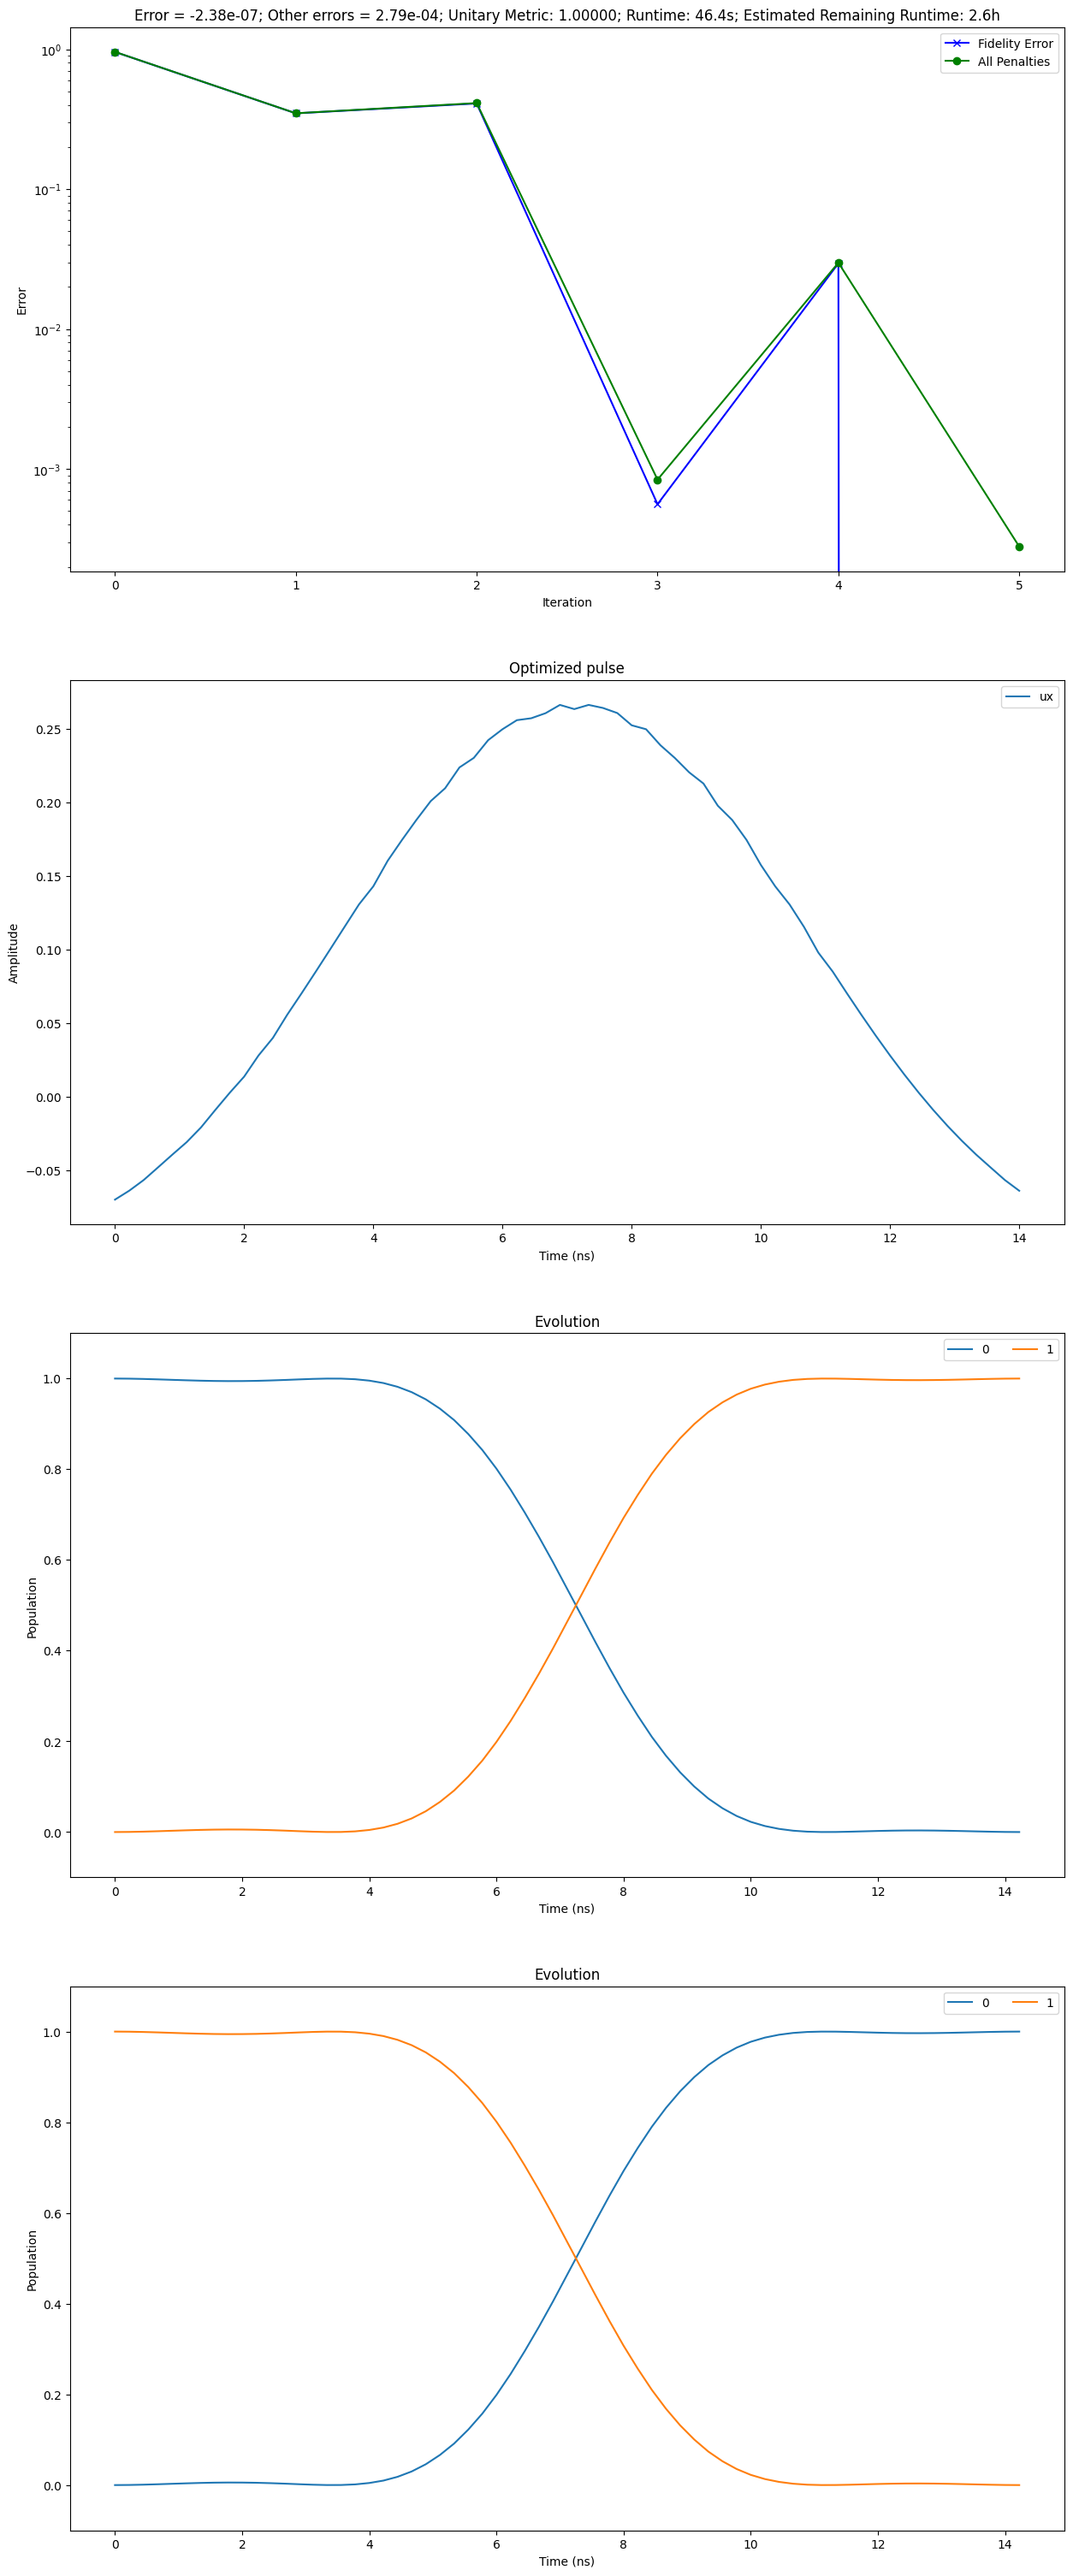

In [7]:
uks, U_final = Grape(H0, Hops, Hnames, U, total_time, steps, psi0,
                    convergence = convergence, 
                    draw = [states_draw_list, states_draw_names],
                    state_transfer = True,
                    use_gpu = False,
                    sparse_H = False,
                    show_plots = True, 
                    unitary_error = 1e-6, 
                    method = 'L-BFGS-B', 
                    maxA = ops_max_amp,
                    Taylor_terms = [20,0] ,
                    reg_coeffs = reg_coeffs,
                    save = True,
                    file_name = 'x01_lagos',
                    data_path = data_path)